In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import archetypes as arch
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import pearsonr
import sklearn.metrics as metrics
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, leaves_list
from pysal.lib import weights
import geopandas as gpd
from shapely.geometry import Point
from pysal.explore import esda
from scipy.spatial.distance import jensenshannon

In [5]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

plt.rcParams['svg.fonttype'] = 'none'
data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/cell2loc_human_lymph_node/'

In [ ]:
# run chrysalis
# calculate SVGs

adata = sc.datasets.visium_sge(sample_id='V1_Human_Lymph_Node')

sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.filter_cells(adata, min_counts=6000)
sc.pp.filter_genes(adata, min_cells=10)

sc.pl.spatial(adata, img_key="hires", color="total_counts", size=1.8, cmap='viridis')

chrysalis_svg(adata, min_morans=0.05, min_spots=0.05)
adata.write(data_path + 'chr.h5ad')

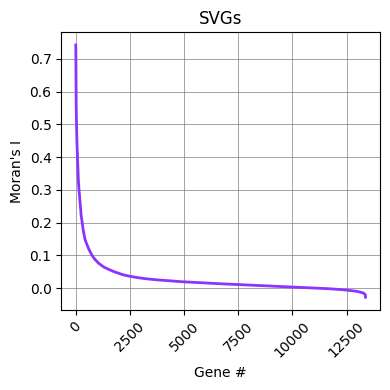

In [6]:
# read back file and proceed with the analysis
adata = sc.read_h5ad(data_path + 'chr.h5ad')

ch.plot_svgs(adata)
plt.show()

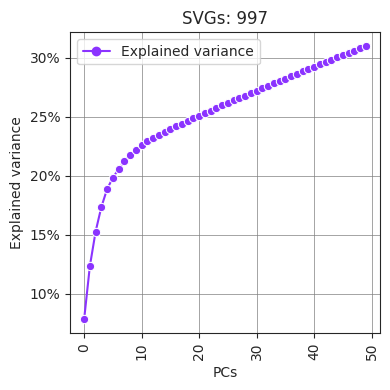

In [7]:
moran_df = adata.var[adata.var["Moran's I"] > 0.08]
adata.var['spatially_variable'] = [True if x in moran_df.index else False for x in adata.var_names]

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=50)

ch.plot_explained_variance(adata)
plt.show()

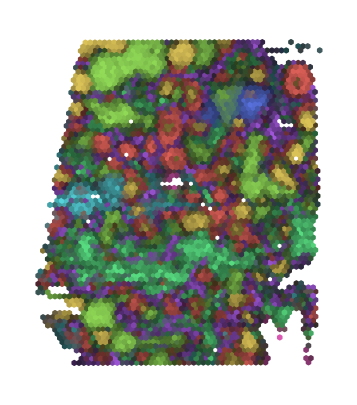

In [8]:
# here we manually define compartment colors
hexcodes = ['#91db57', '#57db80', '#5770db', '#dbc257', '#a157db', '#57d3db', '#db5f57', '#db57b2']

ch.aa(adata, n_pcs=20, n_archetypes=8)
ch.plot(adata, dim=8, hexcodes=hexcodes)
plt.show()

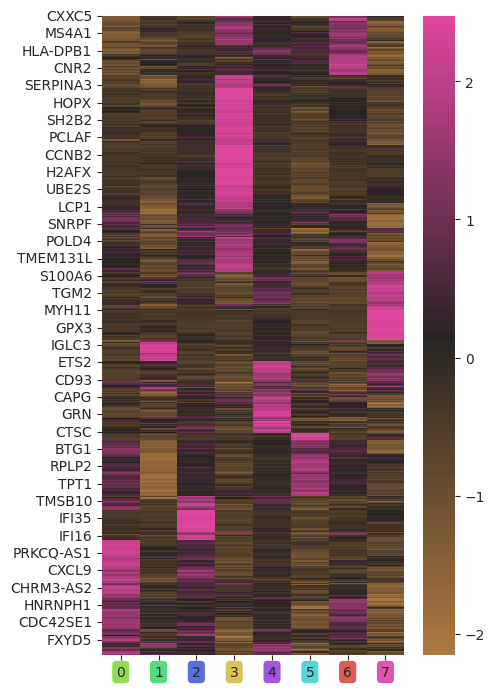

In [9]:
ch.plot_heatmap(adata, hexcodes=hexcodes, rasterized=True)
plt.show()

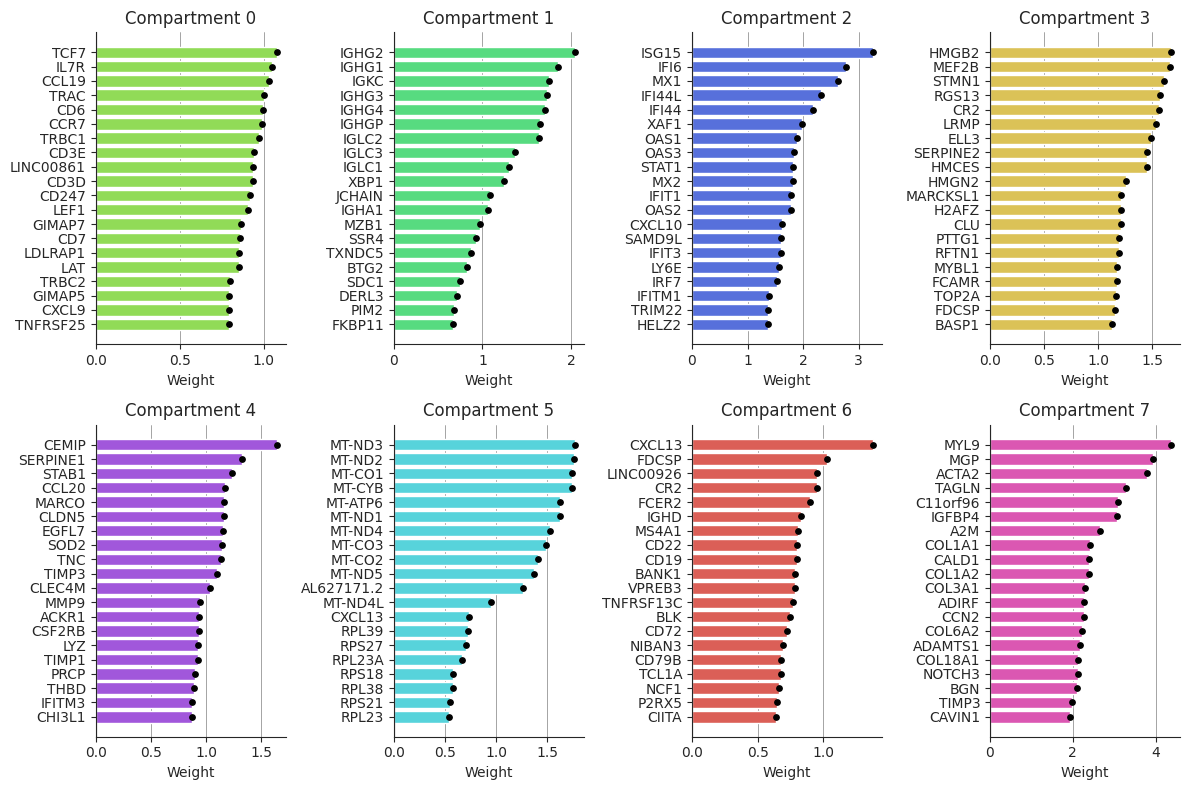

In [10]:
ch.plot_weights(adata, hexcodes=hexcodes)
plt.show()

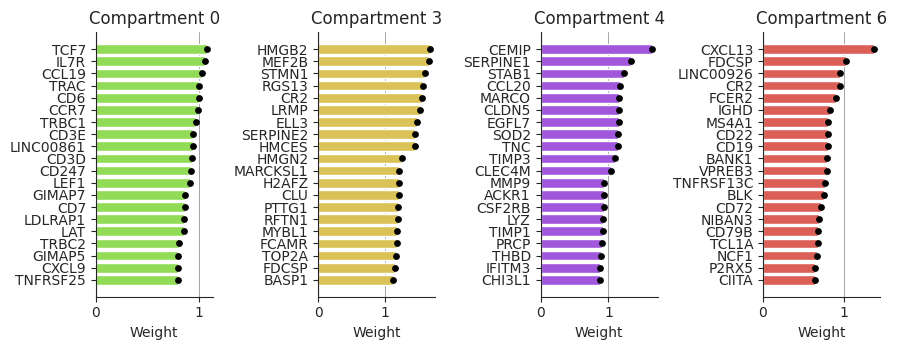

In [11]:
ch.plot_weights(adata, hexcodes=hexcodes, compartments=[0, 3, 4, 6], w=0.75, h=0.9)
plt.show()

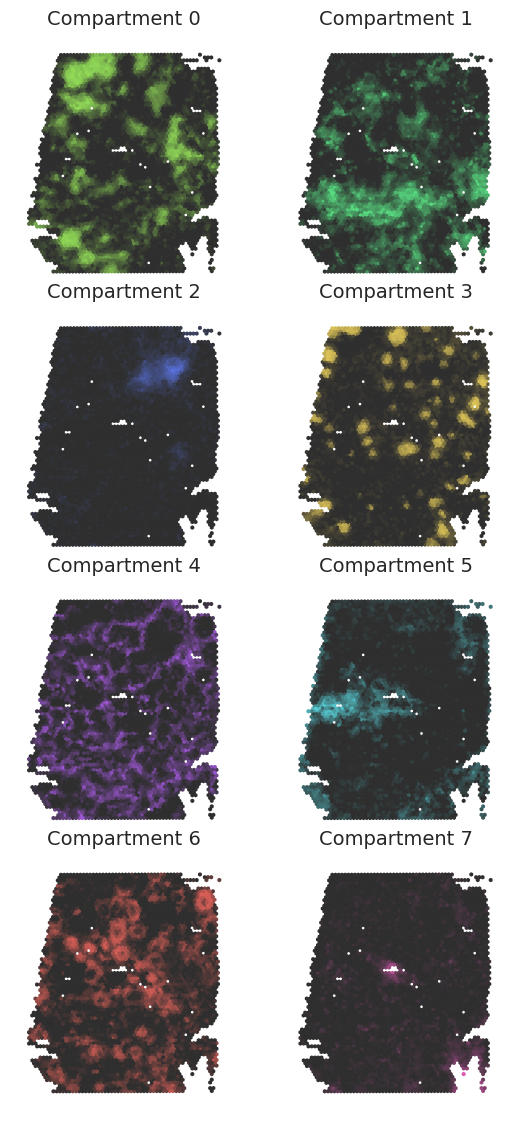

In [12]:
# plot individual compartments
fig, axs = plt.subplots(4, 2, figsize=(10*0.6, 20*0.6))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.05, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)
for i in range(8):
    ch.plot_compartment(adata, fig, axs[i], dim=8, selected_dim=i, color_first='#2e2e2e', spot_size=0.85,
                   hexcodes=hexcodes, rasterized=True)
    axs[i].set_title(f'Compartment {i}', size=14)
plt.show()

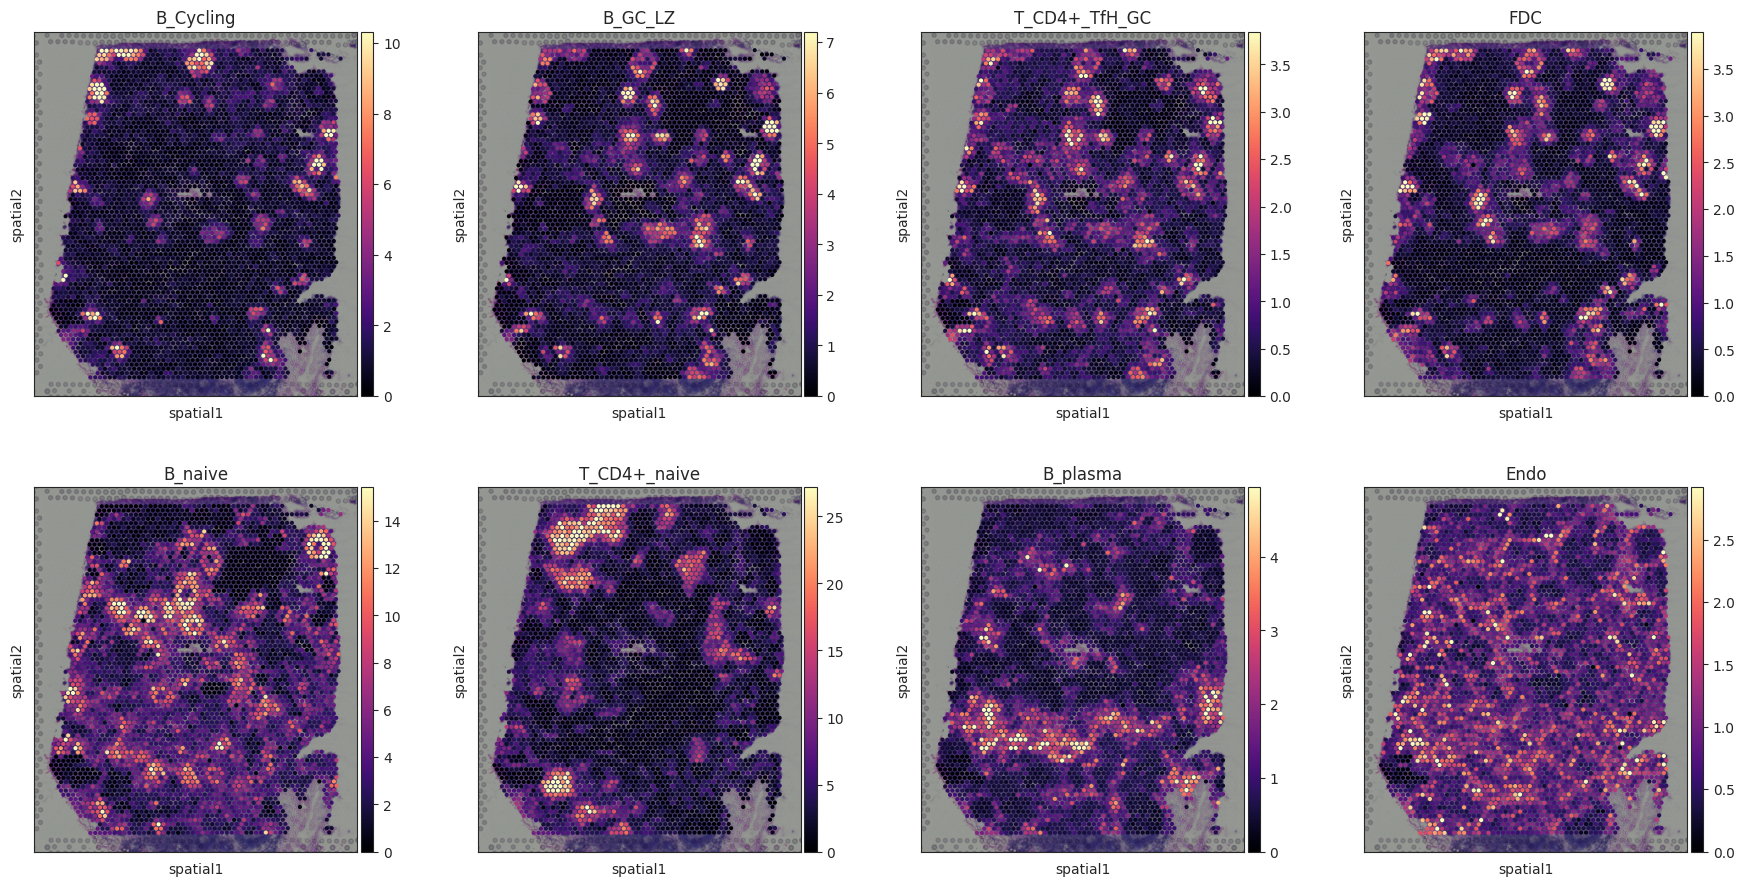

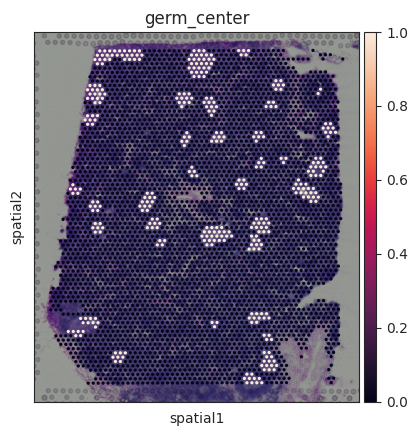

In [13]:
# read cell2loc deconvolution results - colab tutorial
# https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html

ref_adata = sc.read_h5ad(data_path + 'sp.h5ad')

ref_adata.obs[ref_adata.uns['mod']['factor_names']] = ref_adata.obsm['q05_cell_abundance_w_sf']

with mpl.rc_context({'axes.facecolor': 'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(ref_adata, cmap='magma',
                  color=['B_Cycling', 'B_GC_LZ', 'T_CD4+_TfH_GC', 'FDC',
                         'B_naive', 'T_CD4+_naive', 'B_plasma', 'Endo'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  vmin=0, vmax='p99.2'
                  )

# add cell type abundances

ground_truth = pd.read_csv(data_path + 'manual_gc_annot.csv', index_col=0)
adata.obs['germ_center'] = ground_truth['cell_type']
sc.pl.spatial(adata, color=['germ_center'])

cell_types = ref_adata.obs[ref_adata.uns['mod']['factor_names']].columns
adata.obs[cell_types] = ref_adata.obs[ref_adata.uns['mod']['factor_names']]
cell_type_df = adata.obs[cell_types]

In [ ]:
# PC-correlation data
# calculate correlations

rsq_pc = {}
ent_spot_pc = {}
hcorr_pc = {}

# look at different number of PCs and compartments
for npc in [6, 10, 20, 40]:
    rsq = {}
    ent_spot = {}
    hcorr = {}
    for aa in tqdm(range(3, 25)):
        chrysalis_aa(adata, n_pcs=npc, n_archetypes=aa)
        compartment_df = pd.DataFrame(data=adata.obsm['chr_aa'],
                                      index=adata.obs_names,
                                      columns=range(adata.obsm['chr_aa'].shape[1]))

        corr_matrix = np.empty((len(cell_type_df.columns), len(compartment_df.columns)))
        for i, col1 in enumerate(cell_type_df.columns):
            for j, col2 in enumerate(compartment_df.columns):
                corr, _ = pearsonr(cell_type_df[col1], compartment_df[col2])
                corr_matrix[i, j] = corr

        corr_df = pd.DataFrame(data=corr_matrix, index=cell_type_df.columns, columns=compartment_df.columns)

        # get the highest correlations for each cell type
        matching_components = np.argmax(corr_matrix, axis=1)
        highest_corrs = [corr_matrix[i, matching_components[i]] for i in range(len(matching_components))]

        hcorr[aa] = highest_corrs

    hcorr_pc[npc] = list(hcorr.values())

df = pd.DataFrame()
for pc in hcorr_pc.keys():
    for idx, l in zip(range(3, 25), hcorr_pc[pc]):
        for e in l:
            row = pd.Series(data=[e, int(idx), pc])
            df = df.append(row, ignore_index=True)
df = df.rename(columns={0: 'pearsons_r', 1: 'n_compartment', 2: 'n_pc'})
df['n_compartment'] = df['n_compartment'].astype(int)
df['n_pc'] = df['n_pc'].astype(int)
df.to_csv(data_path + 'pearsons_df.csv')

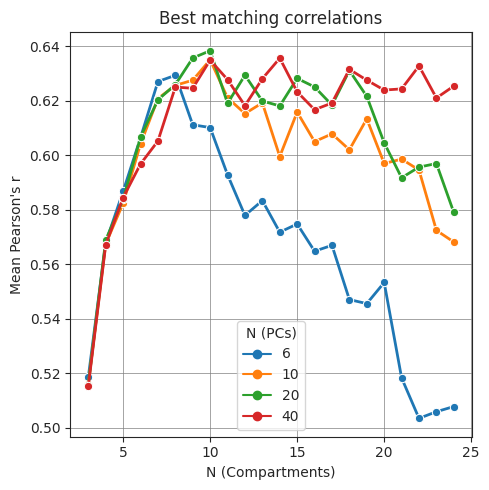

In [14]:
# highest correlation plot
df = pd.read_csv(data_path + 'pearsons_df.csv', index_col=0)
mean_df = pd.DataFrame()
for p in np.unique(df['n_pc']):
    pdf = df[df['n_pc'] == p]
    for c in np.unique(df['n_compartment']):
        subdf = pdf[pdf['n_compartment'] == c]
        subdf['pearsons_r'].mean()
        row = subdf.iloc[0]
        row['pearsons_r'] = subdf['pearsons_r'].mean()
        mean_df = mean_df.append(row)
mean_df['n_compartment'] = mean_df['n_compartment'].astype(int)
mean_df['n_pc'] = mean_df['n_pc'].astype(int)
mean_df['n_pc'] = mean_df['n_pc'].astype('category')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=mean_df, y='pearsons_r', x='n_compartment', hue='n_pc', style='n_pc',
             markers='o', dashes=False, ax=ax, linewidth=2)
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("Mean Pearson's r")
ax.set_xlabel('N (Compartments)')
ax.legend(title="N (PCs)")
ax.set_title(f'Best matching correlations')
plt.tight_layout()
plt.show()

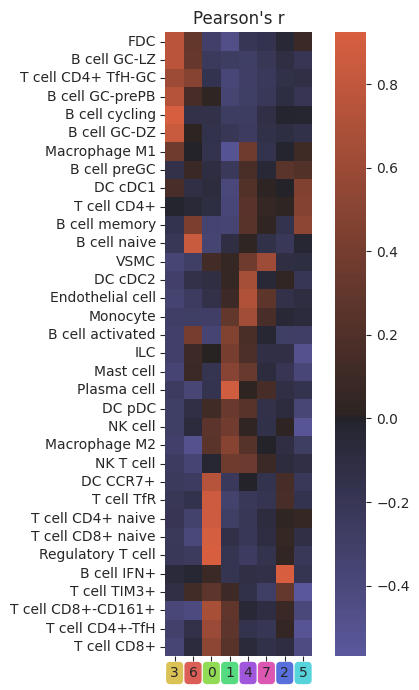

In [15]:
# plot heatmap
compartment_df = pd.DataFrame(data=adata.obsm['chr_aa'],
                              index=adata.obs_names,
                              columns=range(adata.obsm['chr_aa'].shape[1]))

corr_matrix = np.empty((len(cell_type_df.columns), len(compartment_df.columns)))
for i, col1 in enumerate(cell_type_df.columns):
    for j, col2 in enumerate(compartment_df.columns):
        corr, _ = pearsonr(cell_type_df[col1], compartment_df[col2])
        corr_matrix[i, j] = corr

corr_df = pd.DataFrame(data=corr_matrix, index=cell_type_df.columns, columns=compartment_df.columns)

# corr matrix
Z = linkage(corr_df.T, method='ward')
order = leaves_list(Z)
corr_df = corr_df.iloc[:, order]
hexreord =  [hexcodes[i] for i in order]

Z = linkage(corr_df, method='ward')
order = leaves_list(Z)
corr_m = corr_df.iloc[order, :]

corr_m.index = ['FDC', 'B cell GC-LZ', 'T cell CD4+ TfH-GC', 'B cell GC-prePB', 'B cell cycling', 'B cell GC-DZ',
                'Macrophage M1', 'B cell preGC', 'DC cDC1', 'T cell CD4+', 'B cell memory', 'B cell naive',
                'VSMC', 'DC cDC2', 'Endothelial cell', 'Monocyte', 'B cell activated', 'ILC', 'Mast cell',
                'Plasma cell', 'DC pDC', 'NK cell', 'Macrophage M2', 'NK T cell', 'DC CCR7+', 'T cell TfR',
                'T cell CD4+ naive', 'T cell CD8+ naive', 'Regulatory T cell', 'B cell IFN+', 'T cell TIM3+',
                'T cell CD8+-CD161+', 'T cell CD4+-TfH', 'T cell CD8+']

fig, ax = plt.subplots(1, 1, figsize=(5, 7))
sns.heatmap(corr_m, ax=ax, cmap=sns.diverging_palette(267, 20, l=55, center="dark", as_cmap=True),
            center=0, square=True, rasterized=True)
for idx, t in enumerate(ax.get_xticklabels()):
    t.set_bbox(dict(facecolor=hexreord[idx], alpha=1, edgecolor='none', boxstyle='round'))
plt.title("Pearson's r")
plt.tight_layout()
plt.show()

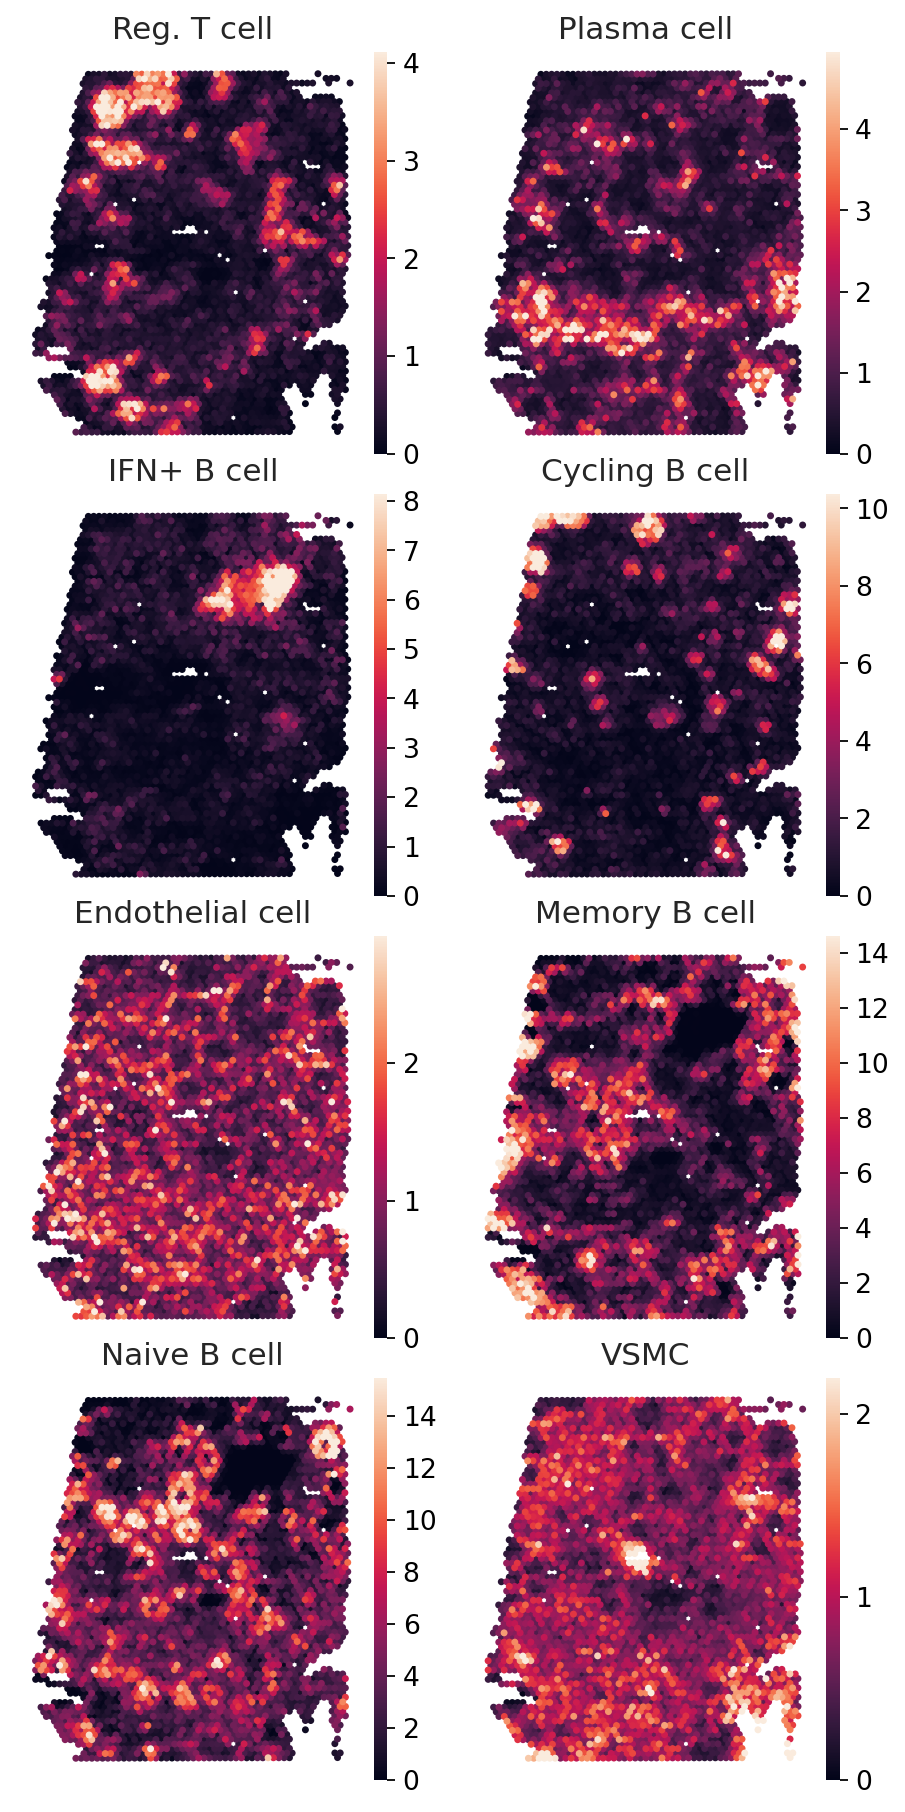

In [16]:
# cell2loc cell types
cells = ['T_Treg', 'B_plasma', 'B_IFN', 'B_Cycling', 'Endo', 'B_mem', 'B_naive', 'VSMC']
cellnames = ['Reg. T cell', 'Plasma cell', 'IFN+ B cell', 'Cycling B cell', 'Endothelial cell',
             'Memory B cell', 'Naive B cell', 'VSMC']
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=12)
fig, axs = plt.subplots(4, 2, figsize=(10*0.6, 20*0.6))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)
for idx, c in enumerate(cells):
    sc.pl.spatial(adata, cmap='rocket',
                  color=c, alpha_img=0,
                  ncols=4, size=2,
                  img_key='hires',
                  vmin=0, vmax='p99.2', ax=axs[idx], show=False
                  )
    axs[idx].set_title(f'{cellnames[idx]}', fontsize=14)
    cbar = fig.axes[-1]
    cbar.set_frame_on(False)
    cbar.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

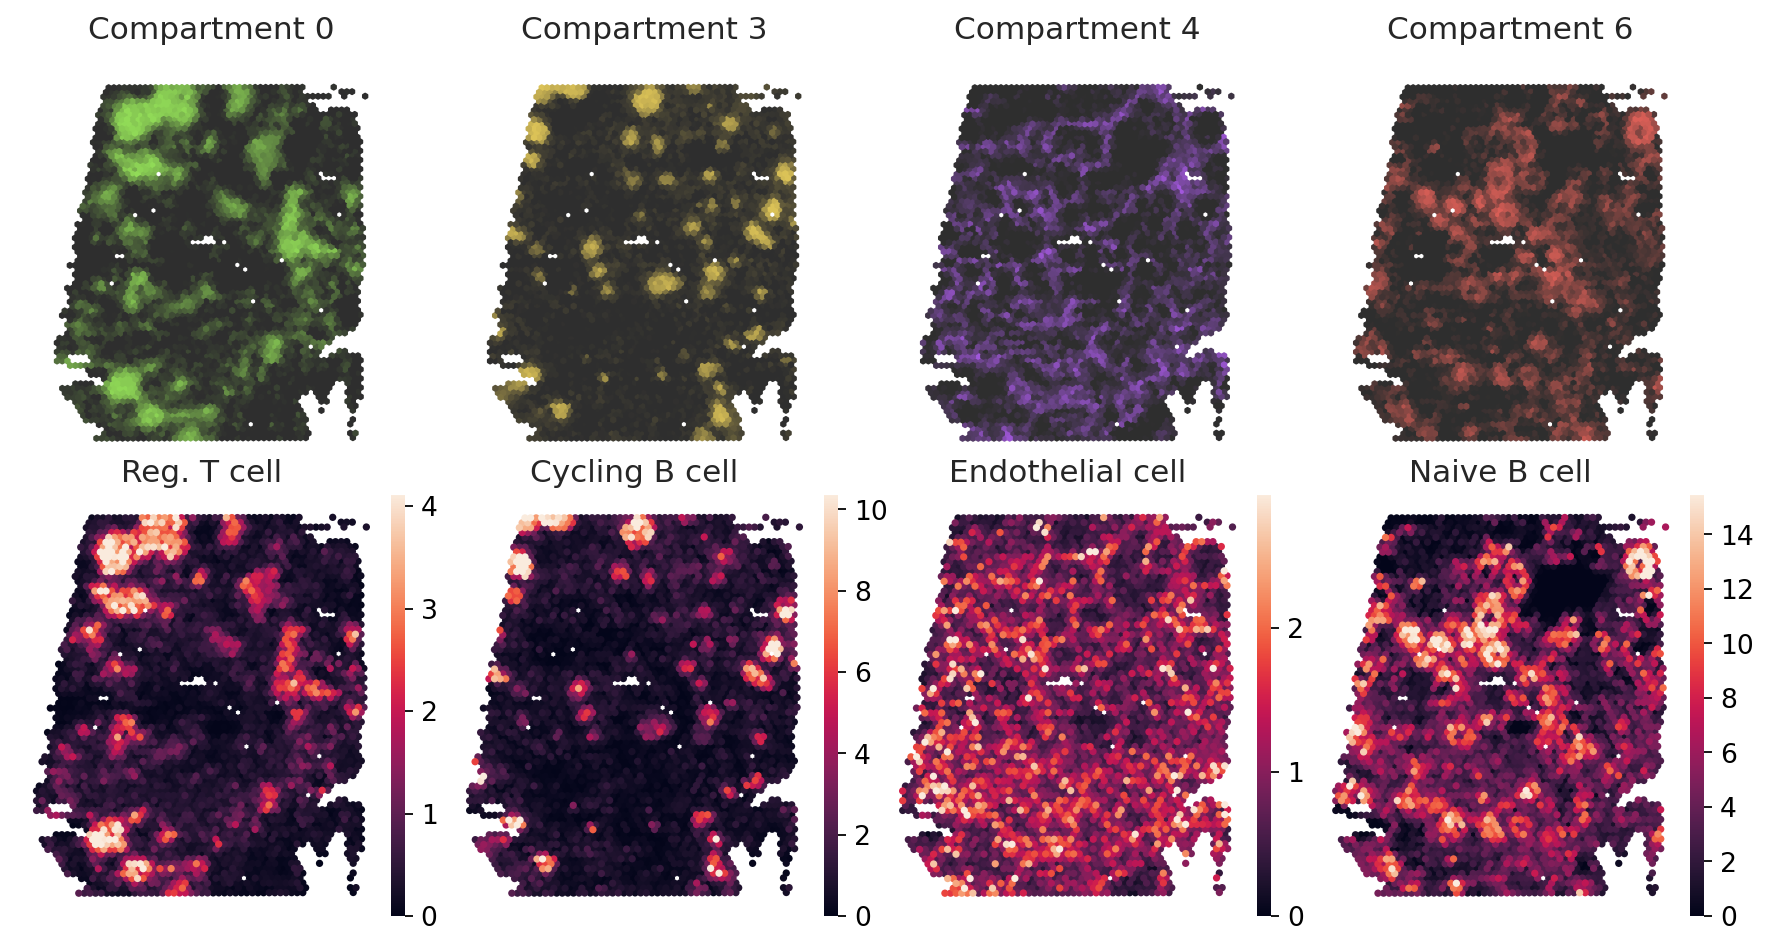

In [17]:
# cell types and compartments for main fig

sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=12)

cells = ['T_Treg', 'B_Cycling', 'Endo', 'B_naive']
cellnames = ['Reg. T cell', 'Cycling B cell', 'Endothelial cell', 'Naive B cell']

fig, axs = plt.subplots(2, 4, figsize=(20*0.6, 10*0.6))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.05, wspace=0.01, left=0.05, right=0.95, top=0.95, bottom=0.05)

for idx, i in enumerate([0, 3, 4, 6]):
    ch.plot_compartment(adata, fig, axs[idx], dim=8, selected_dim=i, color_first='#2e2e2e',
                   spot_size=0.85, hexcodes=hexcodes, rasterized=True)
    axs[idx].set_title(f'Compartment {i}', size=14)

for idx, c in enumerate(cells):
    sc.pl.spatial(adata, cmap='rocket',
                  color=c, alpha_img=0,
                  ncols=4, size=2,
                  img_key='hires',
                  vmin=0, vmax='p99.2', ax=axs[idx + 4], show=False
                  )
    axs[idx + 4].set_title(f'{cellnames[idx]}', fontsize=14)
    cbar = fig.axes[-1]
    cbar.set_frame_on(False)
    cbar.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

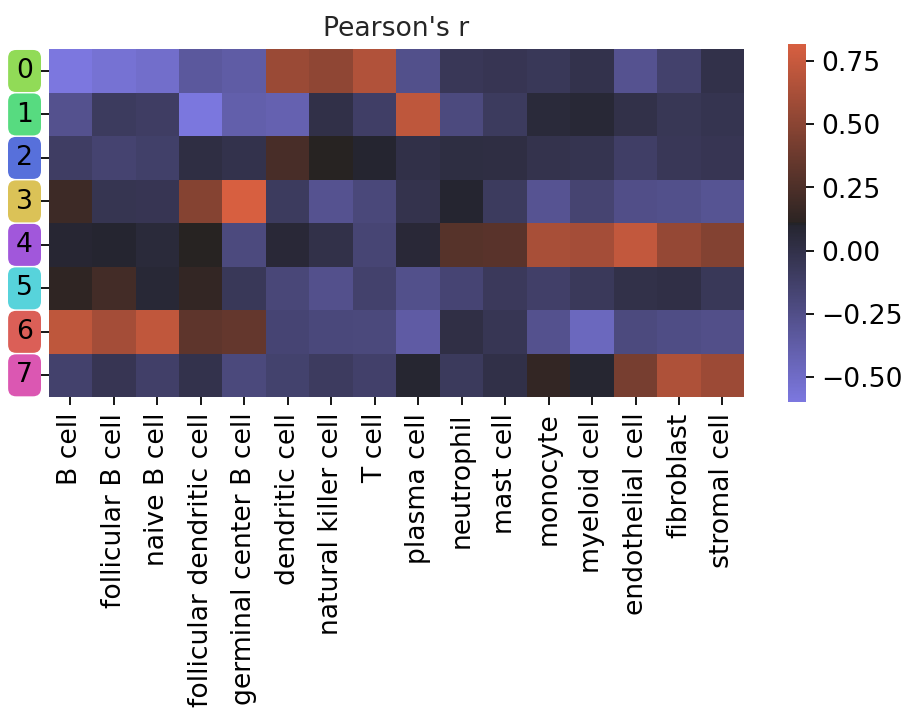

In [18]:
# cellxgene markers
def scanpy_gene_set(adata, gene_list, list_name):
    gene_list = [x for x in gene_list if x in adata.var_names]
    expression = adata.to_df()[gene_list]
    # adata.obs[list_name] = expression.mean(axis=1)
    return expression.mean(axis=1).rename(list_name)

def read_csv_to_dict(file_path):
    result_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            line_parts = line.strip().split(', ')
            key = line_parts[0]
            values = line_parts[1:]
            if key in result_dict:
                result_dict[key].extend(values)
            else:
                result_dict[key] = values
    return result_dict

def get_alpha_df(adata):
    shape = adata.obsm['chr_aa'].shape
    df = pd.DataFrame(data=adata.obsm['chr_aa'], index=adata.obs_names,
                      columns=[f'{i}' for i in range(shape[1])])
    return df


marker_list = read_csv_to_dict('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/lymph_node_markers.txt')

compartments = get_alpha_df(adata)

gene_set_df = pd.DataFrame()
for k, v in marker_list.items():
    ser = scanpy_gene_set(adata, v , k)
    gene_set_df = gene_set_df.append(ser)
gene_set_df = gene_set_df.T

corr_m = pd.concat([compartments, gene_set_df],axis=1).corr()
corr_m = corr_m.drop(index=gene_set_df.columns, columns=compartments.columns)

Z = linkage(corr_m.T, method='ward')
order = leaves_list(Z)
corr_m = corr_m.iloc[:, order]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(corr_m, ax=ax, cmap=sns.diverging_palette(267, 20, l=55, center="dark", as_cmap=True), square=True,
            rasterized=True)
for idx, t in enumerate(ax.get_yticklabels()):
    t.set_bbox(dict(facecolor=hexcodes[idx], alpha=1, edgecolor='none', boxstyle='round'))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Pearson's r")
plt.tight_layout()
plt.show()

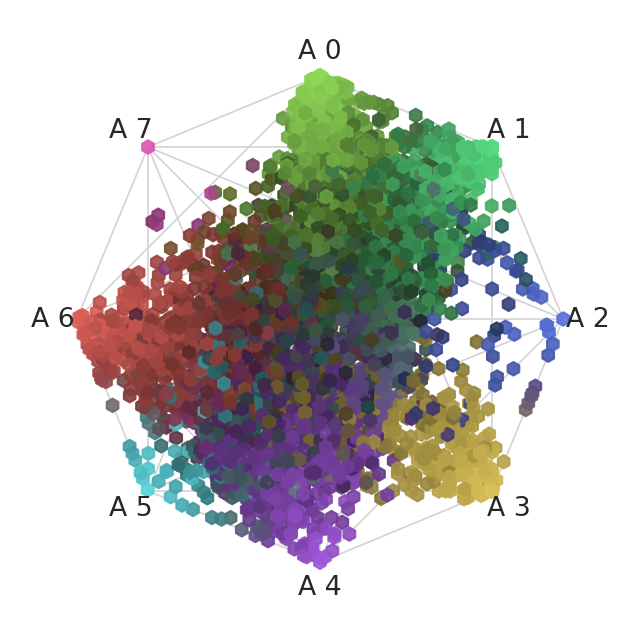

In [19]:
def get_color_blend(adata, dim=8, hexcodes=None, seed=None, color_first='black'):
    # define PC colors
    if hexcodes is None:
        hexcodes = ['#db5f57', '#dbc257', '#91db57', '#57db80', '#57d3db', '#5770db', '#a157db', '#db57b2']
        if seed is None:
            np.random.seed(len(adata))
        else:
            np.random.seed(seed)
        np.random.shuffle(hexcodes)
    else:
        assert len(hexcodes) >= dim
    # define colormaps
    cmaps = []
    for d in range(dim):
        pc_cmap = color_to_color(color_first, hexcodes[d])
        pc_rgb = get_rgb_from_colormap(pc_cmap,
                                       vmin=min(adata.obsm['chr_aa'][:, d]),
                                       vmax=max(adata.obsm['chr_aa'][:, d]),
                                       value=adata.obsm['chr_aa'][:, d])
        cmaps.append(pc_rgb)
    cblend = mip_colors(cmaps[0], cmaps[1],)
    if len(cmaps) > 2:
        i = 2
        for cmap in cmaps[2:]:
            cblend = mip_colors(cblend, cmap,)
            i += 1
    return cblend

def color_to_color(first, last):
    # define the colors in the colormap
    colors = [first, last]
    # create a colormap object using the defined colors
    cmap = mcolors.LinearSegmentedColormap.from_list("", colors)
    return cmap

def get_rgb_from_colormap(cmap, vmin, vmax, value):
    # normalize the value within the range [0, 1]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    value_normalized = norm(value)

    # get the RGBA value from the colormap
    rgba = plt.get_cmap(cmap)(value_normalized)
    # convert the RGBA value to RGB
    # color = tuple(np.array(rgba[:3]) * 255)
    color = np.array(rgba[:, :3])
    return color

def mip_colors(colors_1, colors_2):
    # blend the colors using linear interpolation
    mip_color = []
    for i in range(len(colors_1)):
        r = max(colors_1[i][0], colors_2[i][0])
        g = max(colors_1[i][1], colors_2[i][1])
        b = max(colors_1[i][2], colors_2[i][2])
        mip_color.append((r, g, b))
    return mip_color

cblend = get_color_blend(adata, hexcodes=hexcodes)

plt.figure(figsize=(5, 5))
arch.simplex(adata.obsm['chr_aa'], c=cblend, alpha=0.9, show_circle=False, show_direction=False, direction_alpha=0.1,
             marker='h', rasterized=True)
plt.show()


In [20]:
# germinal center ground truth
adata.obs['chr_gc'] = adata.obsm['chr_aa'][:, 3]


In [21]:
# scanpy PCA

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

scanpy_df = pd.DataFrame(adata.obsm['X_pca'])

aucs = []
for c in scanpy_df.columns:
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(scanpy_df[c]),
                                            drop_intermediate=True)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)

x_scaled = (scanpy_df[0] - np.min(scanpy_df[0])) / (np.max(scanpy_df[0]) - np.min(scanpy_df[0]))
adata.obs['sc_gc'] = list(x_scaled)


In [22]:
# SpatialPCA
# look for the highest ROC-AUC amongst the components

spapca_df = pd.read_csv(data_path + 'spatialpca/spatial_pcs.csv', index_col=0).T

aucs = []
for c in spapca_df.columns:
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(spapca_df[c]),
                                            drop_intermediate=True)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)

x = spapca_df.iloc[:, np.argmax(aucs)]
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
adata.obs['sppca_gc'] = x_scaled


In [23]:
# MEFISTO
# look for the highest ROC-AUC amongst the components

meph_df = pd.read_csv(data_path + 'mefisto/factors.csv', index_col=0)

aucs = []
for c in meph_df.columns:
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(meph_df[c]),
                                            drop_intermediate=True)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)

x = meph_df.iloc[:, np.argmax(aucs)]
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
adata.obs['mef_gc'] = x_scaled


In [24]:
# STAGATE results
# look for the highest ROC-AUC amongst the components

stagate_df = pd.read_csv(data_path + 'stagate_lymph_node.csv', index_col=0)

aucs = []
for c in stagate_df.columns:
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(stagate_df[c]),
                                            drop_intermediate=True)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)

x = stagate_df.iloc[:, np.argmax(aucs)]
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
adata.obs['stg_gc'] = x_scaled


In [25]:
# NSF results
import pickle
import math

file = open(data_path + '/human_lymph_node_nsf.pkl', 'rb')
data = pickle.load(file)
file.close()


def transform_coords(X):
    # code from nsf github
    X[:, 1] = -X[:, 1]
    xmin = X.min(axis=0)
    X -= xmin
    x_gmean = np.exp(np.mean(np.log(X.max(axis=0))))
    X *= 4 / x_gmean
    return X - X.mean(axis=0)


X = adata.obsm["spatial"].copy().astype('float32')
tcoords = transform_coords(X)

pair_idx = []
for xy in data['positions']:
    distances = [math.dist([xy[0], xy[1]], [idx[0], idx[1]]) for idx in tcoords]
    pair_idx.append(np.argmin(distances))

nsf_df = pd.DataFrame(data=np.zeros([len(adata), data['factors']['factors'].shape[1]]))
for idx, i in enumerate(pair_idx):
    nsf_df.iloc[i, :] = data['factors']['factors'][idx, :]
nsf_df.index = adata.obs.index

aucs = []
for c in nsf_df.columns:
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(nsf_df[c]),
                                            drop_intermediate=True)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)

x = nsf_df.iloc[:, np.argmax(aucs)]
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
adata.obs['nsf_gc'] = x_scaled


In [26]:
# GraphST results
# look for the highest ROC-AUC amongst the components

graphst_df = pd.read_csv(data_path + 'graphst_lymph_node.csv', index_col=0)
graphst_df.index = adata.obs.index

pca = PCA(n_components=20, svd_solver='arpack', random_state=42)
graphst_pcs = pca.fit_transform(graphst_df)
graphst_pcs_df = pd.DataFrame(data=graphst_pcs, index=graphst_df.index)

aucs = []
for c in graphst_pcs_df.columns:
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(graphst_pcs_df[c]),
                                            drop_intermediate=True)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)

x = graphst_pcs_df.iloc[:, np.argmax(aucs)]
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
adata.obs['gst_gc'] = x_scaled

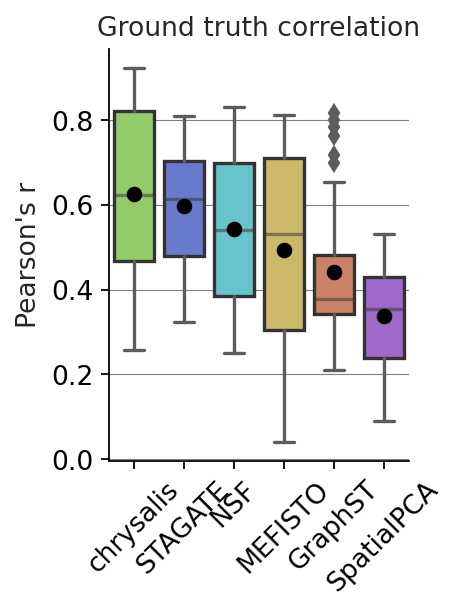

In [27]:
# avg correlations for the methods

compartment_df = pd.DataFrame(data=adata.obsm['chr_aa'],
                              index=adata.obs_names,
                              columns=range(adata.obsm['chr_aa'].shape[1]))

mdf_dict = {
    'chrysalis': [compartment_df, '#91db57'],
    'NSF': [nsf_df, '#57d3db'],
    'STAGATE': [stagate_df, '#5770db'],
    'MEFISTO': [meph_df, '#dbc257'],
    'SpatialPCA': [spapca_df, '#a157db'],
    'GraphST': [graphst_pcs_df, '#db7c57']
}

method_cdf = pd.DataFrame(columns=mdf_dict.keys(), index=cell_type_df.columns)
for k, v in mdf_dict.items():

    corr_matrix = np.empty((len(cell_type_df.columns), len(v[0].columns)))

    for i, col1 in enumerate(cell_type_df.columns):
        for j, col2 in enumerate(v[0].columns):
            corr, _ = pearsonr(cell_type_df[col1], v[0][col2])
            corr_matrix[i, j] = corr

    corr_df = pd.DataFrame(data=corr_matrix, index=cell_type_df.columns, columns=v[0].columns)
    method_cdf[k] = corr_df.T.max()

method_cdf = method_cdf.reindex(method_cdf.mean().sort_values(ascending=False).index, axis=1)
colors = [mdf_dict[k][1] for k in method_cdf.columns]

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
sns.boxplot(method_cdf, palette=colors, boxprops={'edgecolor': "0.2"}, medianprops={"color": "0.2", 'alpha': 0.5},
            showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
ax.set_title('Ground truth correlation')
ax.set_ylabel("Pearson's r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

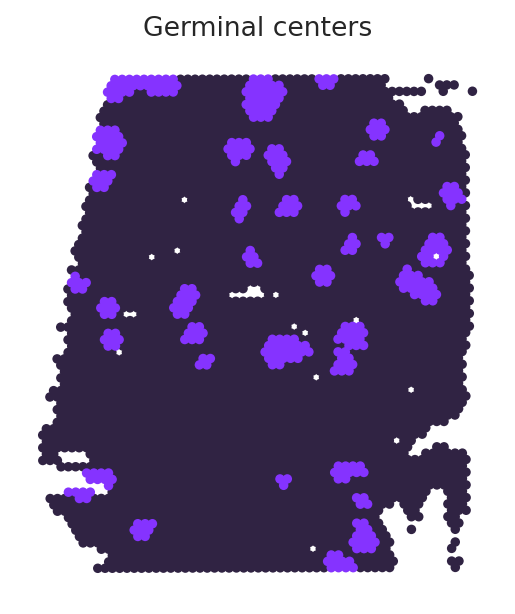

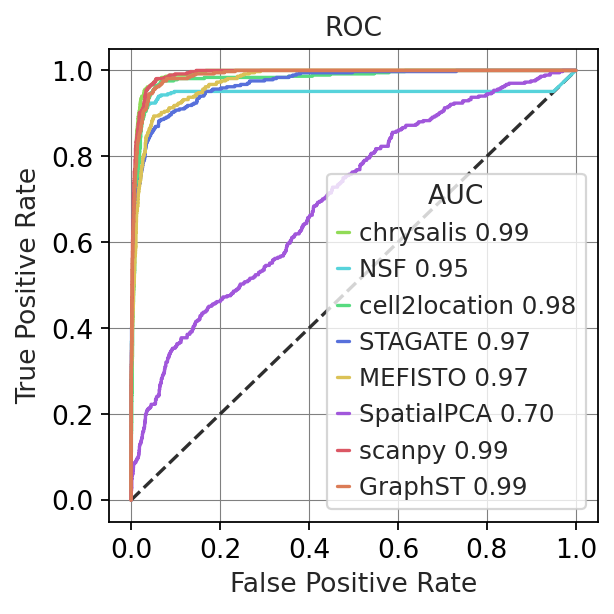

In [28]:

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.spatial(adata, color=['germ_center'], alpha_img=0, frameon=False, size=2,
              show=False, ax=ax, cmap=color_to_color('#302343', '#8533ff'),
              legend_loc='none')
ax.set_title('Germinal centers')
cbar = fig.axes[-1]
cbar.remove()
plt.tight_layout()
# plt.savefig('/mnt/c/Users/demeter_turos/Desktop/svgs/germ_center_spatial.png', transparent=True)
plt.show()

x = adata.obs[['B_GC_DZ', 'B_GC_LZ', 'B_Cycling', 'T_CD4+_TfH_GC', 'B_GC_prePB', 'FDC']].sum(axis=1)
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
adata.obs['c2l_gc'] = x_scaled

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
ax.plot([0, 1], [0, 1], color='#2e2e2e', linestyle='dashed')

md_dict = {
    'chrysalis': [adata.obs['chr_gc'], '#91db57'],
    'NSF': [adata.obs['nsf_gc'], '#57d3db'],
    'cell2location': [adata.obs['c2l_gc'], '#57db80'],
    'STAGATE': [adata.obs['stg_gc'], '#5770db'],
    'MEFISTO': [adata.obs['mef_gc'], '#dbc257'],
    'SpatialPCA': [adata.obs['sppca_gc'], '#a157db'],
    'scanpy': [adata.obs['sc_gc'], '#db5764'],
    'GraphST': [adata.obs['gst_gc'], '#db7c57']
}

for k, v in md_dict.items():
    fpr, tpr, threshold = metrics.roc_curve(list(adata.obs['germ_center']), list(v[0]), drop_intermediate=False)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    ax.plot(fpr, tpr, c=v[1], alpha=1, linewidth='1.5', label = f'{k} %0.2f' % roc_auc)

ax.set_title('ROC')
ax.legend(loc='lower right', title='AUC')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

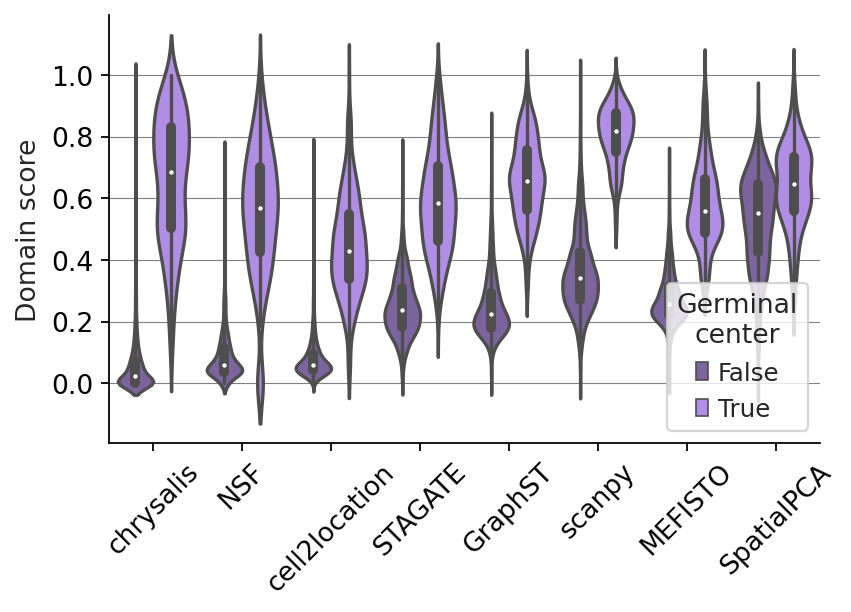

In [29]:
# JS distance - KL divergence

cols = ['chr_gc', 'nsf_gc', 'c2l_gc', 'stg_gc', 'gst_gc', 'sppca_gc','sc_gc', 'mef_gc']
mnames = ['chrysalis', 'NSF', 'cell2location', 'STAGATE', 'GraphST', 'SpatialPCA', 'scanpy', 'MEFISTO']
colors = ['#91db57', '#57d3db', '#57db80', '#5770db', '#db7c57', '#a157db', '#db5764', '#dbc257']

long_df = pd.melt(adata.obs,
                  value_vars=cols,
                  id_vars=['germ_center'])

np.random.seed(42)
m_dict = {}
for m in cols:
    method_df = long_df[long_df['variable'] == m]

    draws = []
    neg_vals = list(method_df[method_df['germ_center'] == 0]['value'])
    pos_vals = list(method_df[method_df['germ_center'] == 1]['value'])
    for i in range(1000):
        neg_vals = np.random.choice(neg_vals, size=len(pos_vals), replace=False)
        draws.append(jensenshannon(neg_vals, pos_vals))
    m_dict[m] = draws

m_df = pd.DataFrame(m_dict)

means = pd.DataFrame(m_df.mean())
means['names'] = mnames
means['colors'] = colors
means = means.sort_values(by=0, ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
sns.violinplot(long_df, hue='germ_center', y='value', x='variable', scale='width',
               palette=['#7a5ba9', '#ae7ff5'], order=means.index)
ax.set_ylabel('Domain score')
ax.set_xlabel(None)
ax.set_xticklabels(means['names'], rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legend_labels = ['False', 'True']
handles, _ = ax.get_legend_handles_labels()
legend = ax.legend(handles, legend_labels, loc='lower right', title='Germinal\ncenter')
legend.get_title().set_ha('center')
plt.tight_layout()
plt.show()

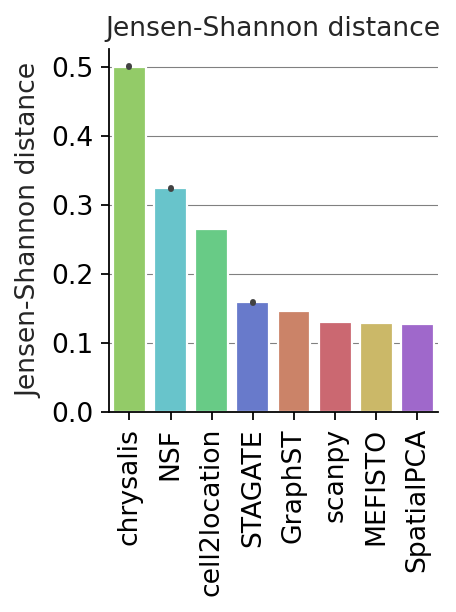

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
sns.barplot(m_df, palette=means['colors'], order=list(means.index))
ax.set_title('Jensen-Shannon distance')
ax.set_ylabel('Jensen-Shannon distance')
ax.set_xticklabels(means['names'], rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

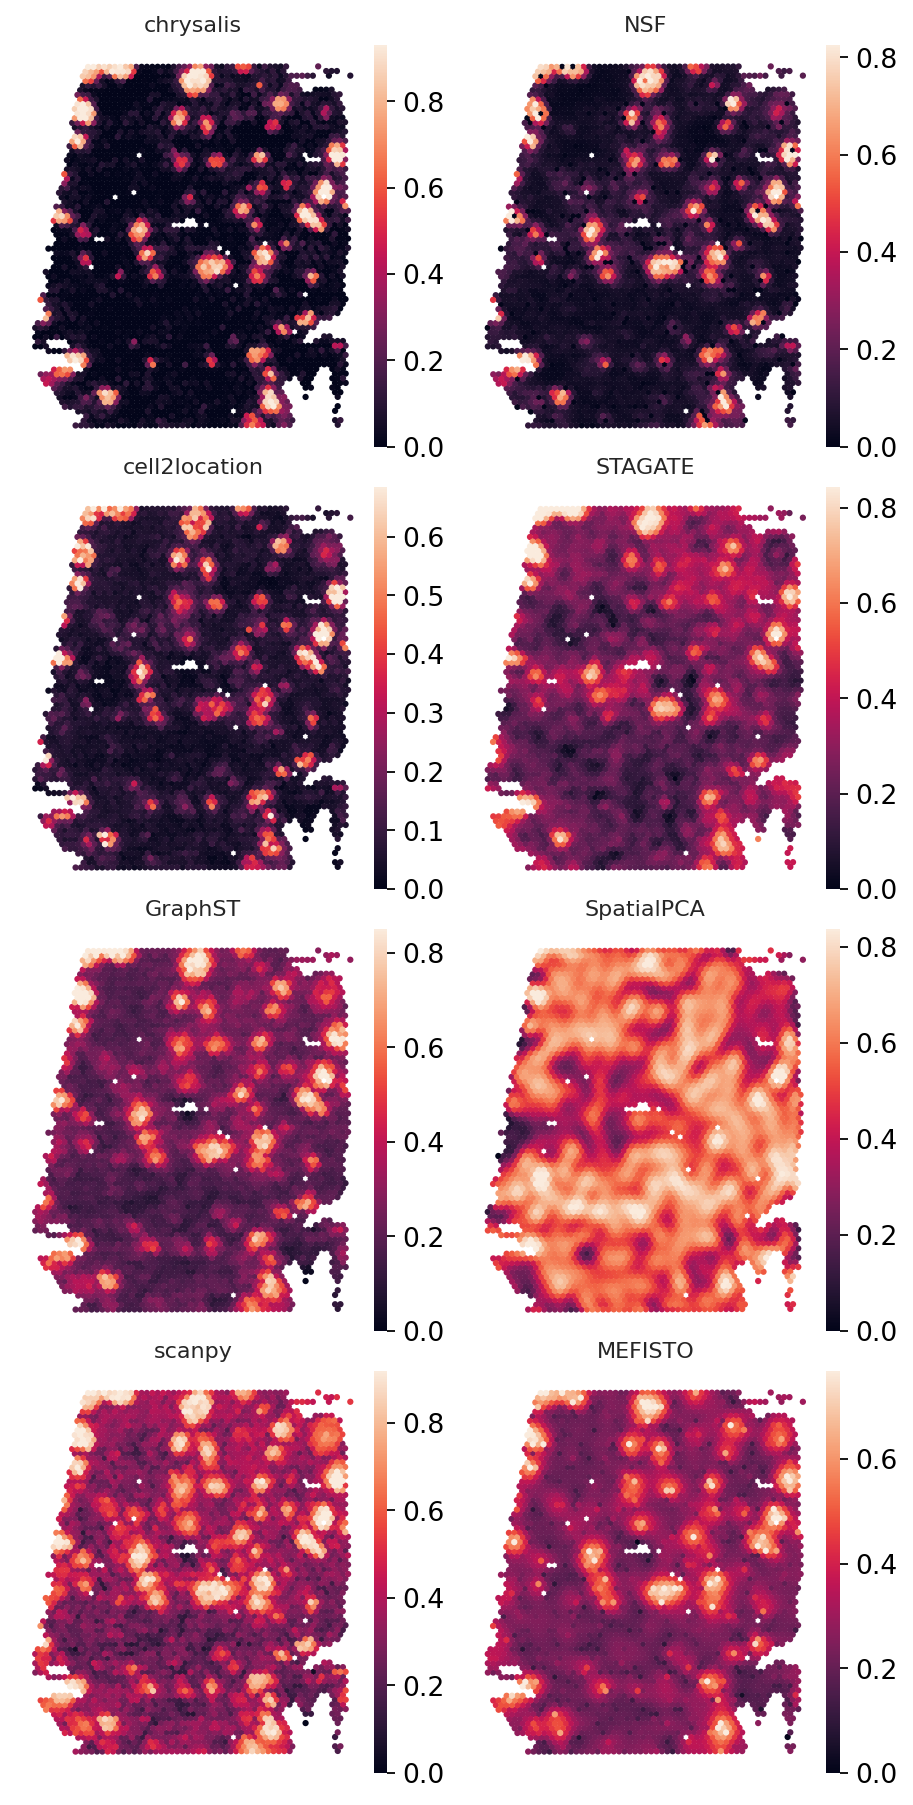

In [31]:
# domains

gc_methods = ['chr_gc', 'nsf_gc', 'c2l_gc', 'stg_gc', 'gst_gc', 'sppca_gc','sc_gc', 'mef_gc']
method_names = ['chrysalis', 'NSF', 'cell2location', 'STAGATE', 'GraphST', 'SpatialPCA', 'scanpy', 'MEFISTO']

sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=12)

fig, axs = plt.subplots(4, 2, figsize=(10*0.6, 20*0.6))
axs = axs.flatten()
for a in axs:
    a.axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)
for idx, c in enumerate(gc_methods):
    sc.pl.spatial(adata, cmap='rocket',
                  color=c, alpha_img=0,
                  ncols=4, size=1.8,
                  img_key='hires',
                  vmin=0, vmax='p99.2', ax=axs[idx], show=False
                  )
    axs[idx].set_title(f'{method_names[idx]}', fontsize=10)
    cbar = fig.axes[-1]
    cbar.set_frame_on(False)
plt.show()
